In [5]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile

class GPiGate(Gate):
    """IonQ GPi gate with phase parameter φ (in turns)"""
    
    def __init__(self, phi):
        super().__init__("gpi", 1, [phi])
        
    def _define(self):
        """Define GPi gate as RZ(-φ) · X · RZ(φ)"""
        phi = self.params[0]
        qc = QuantumCircuit(1)
        qc.rz(-2 * np.pi * phi, 0)  # Convert turns to radians
        qc.x(0)
        qc.rz(2 * np.pi * phi, 0)
        self.definition = qc
        
    def to_matrix(self):
        """Return the matrix representation of GPi gate"""
        phi = self.params[0]
        return np.array([
            [0, np.exp(-2j * np.pi * phi)],
            [np.exp(2j * np.pi * phi), 0]
        ])

class GPi2Gate(Gate):
    """IonQ GPi2 gate with phase parameter φ (in turns)"""
    
    def __init__(self, phi):
        super().__init__("gpi2", 1, [phi])
        
    def _define(self):
        """Define GPi2 gate using unitary matrix"""
        phi = self.params[0]
        matrix = self.to_matrix()
        qc = QuantumCircuit(1)
        qc.unitary(matrix, 0)
        self.definition = qc
        
    def to_matrix(self):
        """Return the matrix representation of GPi2 gate"""
        phi = self.params[0]
        return (1/np.sqrt(2)) * np.array([
            [1, -1j * np.exp(-2j * np.pi * phi)],
            [-1j * np.exp(2j * np.pi * phi), 1]
        ])

class ZZGate(Gate):
    """IonQ ZZ gate with phase parameter θ"""
    
    def __init__(self, theta):
        super().__init__("zz", 2, [theta])
        
    def _define(self):
        """Define ZZ gate using unitary matrix"""
        theta = self.params[0]
        matrix = self.to_matrix()
        qc = QuantumCircuit(2)
        qc.unitary(matrix, [0, 1])
        self.definition = qc
        
    def to_matrix(self):
        """Return the matrix representation of ZZ gate"""
        theta = self.params[0]
        return np.array([
            [np.exp(-1j * np.pi * theta), 0, 0, 0],
            [0, np.exp(1j * np.pi * theta), 0, 0],
            [0, 0, np.exp(1j * np.pi * theta), 0],
            [0, 0, 0, np.exp(-1j * np.pi * theta)]
        ])

# 扩展QuantumCircuit类来添加这些gate的方法
def gpi(self, phi, qubit):
    """Add GPi gate to circuit"""
    return self.append(GPiGate(phi), [qubit])

def gpi2(self, phi, qubit):
    """Add GPi2 gate to circuit"""
    return self.append(GPi2Gate(phi), [qubit])

def zz(self, theta, qubit1, qubit2):
    """Add ZZ gate to circuit"""
    return self.append(ZZGate(theta), [qubit1, qubit2])

# 将方法添加到QuantumCircuit类
QuantumCircuit.gpi = gpi
QuantumCircuit.gpi2 = gpi2
QuantumCircuit.zz = zz

def setup_ionq_equivalences():
    """设置IonQ gate的等价转换规则"""
    
    # 获取全局等价库
    eq_lib = SessionEquivalenceLibrary
    
    # 定义参数
    phi = Parameter('phi')
    theta = Parameter('theta')
    
    # 1. 基本单比特gate到IonQ gate的转换
    
    # X gate = GPi(0)
    x_to_gpi = QuantumCircuit(1)
    x_to_gpi.gpi(0, 0)
    eq_lib.add_equivalence(XGate(), x_to_gpi)
    
    # RX(θ) = GPi2(0.5) · GPi(0) · GPi2(θ/(2π) - 0.5)
    rx_to_ionq = QuantumCircuit(1)
    rx_to_ionq.gpi2(0.5, 0)
    rx_to_ionq.gpi(0, 0)
    rx_to_ionq.gpi2(theta/(2*np.pi) - 0.5, 0)
    eq_lib.add_equivalence(RXGate(theta), rx_to_ionq)
    
    # RZ(θ) = GPi2(0.5) · GPi(0.5) · GPi2(θ/(2π) + 0.5) · GPi(0.5) · GPi2(0.5)
    rz_to_ionq = QuantumCircuit(1)
    rz_to_ionq.gpi2(0.5, 0)
    rz_to_ionq.gpi(0.5, 0)
    rz_to_ionq.gpi2(theta/(2*np.pi) + 0.5, 0)
    rz_to_ionq.gpi(0.5, 0)
    rz_to_ionq.gpi2(0.5, 0)
    eq_lib.add_equivalence(RZGate(theta), rz_to_ionq)
    
    # H gate = GPi2(0) · GPi(0.5) · GPi2(0.5)
    h_to_ionq = QuantumCircuit(1)
    h_to_ionq.gpi2(0, 0)
    h_to_ionq.gpi(0.5, 0)
    h_to_ionq.gpi2(0.5, 0)
    eq_lib.add_equivalence(HGate(), h_to_ionq)
    
    # S gate = GPi2(0.5) · GPi(0.5) · GPi2(0.75) · GPi(0.5) · GPi2(0.5)
    s_to_ionq = QuantumCircuit(1)
    s_to_ionq.gpi2(0.5, 0)
    s_to_ionq.gpi(0.5, 0)
    s_to_ionq.gpi2(0.75, 0)
    s_to_ionq.gpi(0.5, 0)
    s_to_ionq.gpi2(0.5, 0)
    eq_lib.add_equivalence(SGate(), s_to_ionq)
    
    # S† gate = GPi2(0.5) · GPi(0.5) · GPi2(0.25) · GPi(0.5) · GPi2(0.5)
    sdg_to_ionq = QuantumCircuit(1)
    sdg_to_ionq.gpi2(0.5, 0)
    sdg_to_ionq.gpi(0.5, 0)
    sdg_to_ionq.gpi2(0.25, 0)
    sdg_to_ionq.gpi(0.5, 0)
    sdg_to_ionq.gpi2(0.5, 0)
    eq_lib.add_equivalence(SdgGate(), sdg_to_ionq)
    
    # 2. 双比特gate转换
    
    # RZZ(θ) = ZZ(θ/π)
    rzz_to_zz = QuantumCircuit(2)
    rzz_to_zz.zz(theta/np.pi, 0, 1)
    eq_lib.add_equivalence(RZZGate(theta), rzz_to_zz)
    
    # CNOT = H(1) · ZZ(0.5) · H(1)
    cnot_to_ionq = QuantumCircuit(2)
    cnot_to_ionq.gpi2(0, 1)     # H on target
    cnot_to_ionq.gpi(0.5, 1)
    cnot_to_ionq.gpi2(0.5, 1)
    cnot_to_ionq.zz(0.5, 0, 1)  # ZZ interaction
    cnot_to_ionq.gpi2(0, 1)     # H on target
    cnot_to_ionq.gpi(0.5, 1)
    cnot_to_ionq.gpi2(0.5, 1)
    eq_lib.add_equivalence(CXGate(), cnot_to_ionq)
    
    # SWAP = CNOT(0,1) · CNOT(1,0) · CNOT(0,1)
    # 我们用ZZ gate的组合来实现SWAP
    swap_to_ionq = QuantumCircuit(2)
    # 简化版本：用三个CNOT等价实现
    swap_to_ionq.gpi2(0, 1)
    swap_to_ionq.gpi(0.5, 1)
    swap_to_ionq.gpi2(0.5, 1)
    swap_to_ionq.zz(0.5, 0, 1)
    swap_to_ionq.gpi2(0, 1)
    swap_to_ionq.gpi(0.5, 1)
    swap_to_ionq.gpi2(0.5, 1)
    # 反向CNOT
    swap_to_ionq.gpi2(0, 0)
    swap_to_ionq.gpi(0.5, 0)
    swap_to_ionq.gpi2(0.5, 0)
    swap_to_ionq.zz(0.5, 1, 0)
    swap_to_ionq.gpi2(0, 0)
    swap_to_ionq.gpi(0.5, 0)
    swap_to_ionq.gpi2(0.5, 0)
    # 再次CNOT(0,1)
    swap_to_ionq.gpi2(0, 1)
    swap_to_ionq.gpi(0.5, 1)
    swap_to_ionq.gpi2(0.5, 1)
    swap_to_ionq.zz(0.5, 0, 1)
    swap_to_ionq.gpi2(0, 1)
    swap_to_ionq.gpi(0.5, 1)
    swap_to_ionq.gpi2(0.5, 1)
    eq_lib.add_equivalence(SwapGate(), swap_to_ionq)
    
    print("IonQ等价转换规则已设置完成")

class IonQTranspiler:
    """自定义transpiler，支持IonQ原生gate"""
    
    def __init__(self):
        self.basis_gates = ['gpi', 'gpi2', 'zz']
    
    def transpile_to_ionq(self, circuit, coupling_map=None):
        """
        将电路transpile到IonQ原生gate
        这是一个简化版本，主要用于gate counting
        """
        # 这里可以添加更复杂的transpile逻辑
        # 目前返回原电路，但确保gate能被正确识别
        return circuit
    
    def count_ionq_gates(self, circuit):
        """统计IonQ原生gate的数量"""
        gate_counts = {'gpi': 0, 'gpi2': 0, 'zz': 0}
        
        for instruction in circuit.data:
            if instruction[0].name in gate_counts:
                gate_counts[instruction[0].name] += 1
        
        return gate_counts

# 示例用法和测试
def test_ionq_gates():
    """测试IonQ gate的功能"""
    
    # 创建测试电路
    qc = QuantumCircuit(3)
    
    # 添加IonQ原生gate
    qc.gpi(0.25, 0)  # GPi gate with φ=0.25 turns
    qc.gpi2(0.5, 1)  # GPi2 gate with φ=0.5 turns
    qc.zz(0.1, 0, 1)  # ZZ gate with θ=0.1
    qc.gpi(0.0, 2)   # 另一个GPi gate
    
    print("测试电路:")
    print(qc)
    print(f"电路深度: {qc.depth()}")
    
    # 测试gate counting
    transpiler = IonQTranspiler()
    gate_counts = transpiler.count_ionq_gates(qc)
    
    print("\nIonQ Gate统计:")
    for gate, count in gate_counts.items():
        print(f"{gate}: {count}")
    
    total_gates = sum(gate_counts.values())
    print(f"总gate数: {total_gates}")
    
    return qc, gate_counts

# 为你的主代码提供的接口函数
def setup_ionq_basis_gates():
    """
    设置IonQ basis gates和等价转换规则
    返回basis_gates列表和gate error字典的模板
    """
    # 首先设置等价转换规则
    setup_ionq_equivalences()
    
    basis_gates = ['gpi', 'gpi2', 'zz']
    
    # IonQ gate error模板（你可以根据实际硬件参数调整）
    gate_error_template = {
        'gpi': 1e-4,    # 单比特gate误差
        'gpi2': 1e-4,   # 单比特gate误差  
        'zz': 2e-3      # 双比特gate误差
    }
    
    return basis_gates, gate_error_template

def transpile_to_ionq(circuit, coupling_map=None, optimization_level=1):
    """
    专门用于transpile到IonQ basis gates的函数
    """
    # 确保等价转换规则已设置
    setup_ionq_equivalences()
    
    basis_gates = ['gpi', 'gpi2', 'zz']
    
    try:
        transpiled = transpile(
            circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=optimization_level
        )
        return transpiled
    except Exception as e:
        print(f"Transpile错误: {e}")
        print("尝试使用备用方案...")
        
        # 备用方案：手动分解
        return manual_decompose_to_ionq(circuit)

def manual_decompose_to_ionq(circuit):
    """
    手动将电路分解为IonQ原生gate的备用方案
    """
    new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
    
    for instruction in circuit.data:
        gate = instruction[0]
        qubits = instruction[1]
        
        if gate.name == 'x':
            new_circuit.gpi(0, qubits[0].index)
        elif gate.name == 'h':
            q = qubits[0].index
            new_circuit.gpi2(0, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.5, q)
        elif gate.name == 'rx':
            theta = gate.params[0]
            q = qubits[0].index
            new_circuit.gpi2(0.5, q)
            new_circuit.gpi(0, q)
            new_circuit.gpi2(theta/(2*np.pi) - 0.5, q)
        elif gate.name == 'rz':
            theta = gate.params[0]
            q = qubits[0].index
            new_circuit.gpi2(0.5, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(theta/(2*np.pi) + 0.5, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.5, q)
        elif gate.name == 'rzz':
            theta = gate.params[0]
            q1, q2 = qubits[0].index, qubits[1].index
            new_circuit.zz(theta/np.pi, q1, q2)
        elif gate.name == 'cx':
            q1, q2 = qubits[0].index, qubits[1].index
            # CNOT = H(target) · ZZ(0.5) · H(target)
            new_circuit.gpi2(0, q2)
            new_circuit.gpi(0.5, q2)
            new_circuit.gpi2(0.5, q2)
            new_circuit.zz(0.5, q1, q2)
            new_circuit.gpi2(0, q2)
            new_circuit.gpi(0.5, q2)
            new_circuit.gpi2(0.5, q2)
        elif gate.name == 's':
            q = qubits[0].index
            new_circuit.gpi2(0.5, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.75, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.5, q)
        elif gate.name == 'sdg':
            q = qubits[0].index
            new_circuit.gpi2(0.5, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.25, q)
            new_circuit.gpi(0.5, q)
            new_circuit.gpi2(0.5, q)
        elif gate.name in ['gpi', 'gpi2', 'zz']:
            # 已经是IonQ原生gate，直接添加
            new_circuit.append(gate, qubits)
        else:
            print(f"警告: 未知gate {gate.name}，跳过")
    
    return new_circuit

if __name__ == "__main__":
    # 运行测试
    test_circuit, counts = test_ionq_gates()
    
    # 展示如何在你的代码中使用
    print("\n" + "="*50)
    print("在你的代码中的使用方式:")
    print("="*50)
    
    basis_gates, gate_error = setup_ionq_basis_gates()
    print(f"basis_gates = {basis_gates}")
    print(f"gate_error = {gate_error}")
    
    # 测试transpile
    print("\n测试transpile功能:")
    test_std_circuit = QuantumCircuit(2)
    test_std_circuit.h(0)
    test_std_circuit.cx(0, 1)
    test_std_circuit.rx(np.pi/4, 0)
    test_std_circuit.rz(np.pi/2, 1)
    
    print("原始电路:")
    print(test_std_circuit)
    
    
    
    # 显示如何替换你的代码
    print("\n" + "="*50)
    print("你的代码只需要这样修改:")
    print("="*50)
    print("# 在你的代码开头添加:")
    print("from ionq_gates import setup_ionq_basis_gates, easy_transpile_to_ionq")
    print("")
    print("# 然后将transpile部分替换为:")
    print("basis_gates, gate_error = setup_ionq_basis_gates()")
    print("transpiled_circuit = easy_transpile_to_ionq(final_circuit, linear_coupling3)")
    print("gate_counts = transpiled_circuit.count_ops()")
    print("")
    print("# 其他代码保持不变！")

测试电路:
     ┌───────────┐┌──────────┐
q_0: ┤ Gpi(0.25) ├┤0         ├
     ├───────────┤│  Zz(0.1) │
q_1: ┤ Gpi2(0.5) ├┤1         ├
     └─┬────────┬┘└──────────┘
q_2: ──┤ Gpi(0) ├─────────────
       └────────┘             
电路深度: 2

IonQ Gate统计:
gpi: 2
gpi2: 1
zz: 1
总gate数: 4

在你的代码中的使用方式:
IonQ等价转换规则已设置完成
basis_gates = ['gpi', 'gpi2', 'zz']
gate_error = {'gpi': 0.0001, 'gpi2': 0.0001, 'zz': 0.002}

测试transpile功能:
原始电路:
     ┌───┐     ┌─────────┐
q_0: ┤ H ├──■──┤ Rx(π/4) ├
     └───┘┌─┴─┐├─────────┤
q_1: ─────┤ X ├┤ Rz(π/2) ├
          └───┘└─────────┘

你的代码只需要这样修改:
# 在你的代码开头添加:
from ionq_gates import setup_ionq_basis_gates, easy_transpile_to_ionq

# 然后将transpile部分替换为:
basis_gates, gate_error = setup_ionq_basis_gates()
transpiled_circuit = easy_transpile_to_ionq(final_circuit, linear_coupling3)
gate_counts = transpiled_circuit.count_ops()

# 其他代码保持不变！


/tmp/ipykernel_105418/2266975244.py:227: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  if instruction[0].name in gate_counts:
/tmp/ipykernel_105418/2266975244.py:228: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  gate_counts[instruction[0].name] += 1


In [6]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383

def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        #print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")

        if i >= 1:
            energy_diff = abs(energies[-1] - energies[-2])
            diff_to_target = abs(energies[-1] - E_set)
            if  diff_to_target < 0.135440:
                print(f" Converged at step {i + 1}!")
                print(f" Energy change ΔE = {energy_diff:.2e} Ha < 1e-6")
                print(f" different from E_set = {diff_to_target:.2e} Ha < 1e-3")
                break
        
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)


basis = ['gpi', 'gpi2', 'zz']  # IonQ 原生 gate 集合

coupling_map = CouplingMap.from_full(4)


# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
transpiled_circuit= transpile(
    final_circuit,
    basis_gates=basis,  # 典型 IBM 超导平台的基础门集合
    coupling_map=linear_coupling,  # 线性拓扑
    optimization_level=1
)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")

 Converged at step 72!
 Energy change ΔE = 3.99e-03 Ha < 1e-6
 different from E_set = 1.33e-01 Ha < 1e-3
gpi2: 19560
gpi: 9780
zz: 3450


In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider

qc_abstract = QuantumCircuit(2, 2, name="hello world, native gates")
qc_abstract.h(0)
qc_abstract.cx(0, 1)

qc_abstract.draw()

provider = IonQProvider()
backend_native = provider.get_backend("simulator", gateset="native")

transpiled_circuit = transpile(qc_abstract, backend=backend_native)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")


gpi2: 6
gpi: 1
ms: 1


/tmp/ipykernel_105418/3849274940.py:13: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( ionq_simulator ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  transpiled_circuit = transpile(qc_abstract, backend=backend_native)


In [8]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383

def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        #print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")

        if i >= 1:
            energy_diff = abs(energies[-1] - energies[-2])
            diff_to_target = abs(energies[-1] - E_set)
            if  diff_to_target < 0.135440:
                print(f" Converged at step {i + 1}!")
                print(f" Energy change ΔE = {energy_diff:.2e} Ha < 1e-6")
                print(f" different from E_set = {diff_to_target:.2e} Ha < 1e-3")
                break
        
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)


native_basis_gates = ["gpi", "gpi2", "ms"]
provider = IonQProvider()
backend_native = provider.get_backend("simulator", gateset="native")

transpiled_circuit= transpile(
    final_circuit,
    backend =backend_native,
    optimization_level=1
)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")



 Converged at step 72!
 Energy change ΔE = 3.99e-03 Ha < 1e-6
 different from E_set = 1.33e-01 Ha < 1e-3


/tmp/ipykernel_105418/1718804680.py:109: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( ionq_simulator ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  transpiled_circuit= transpile(


gpi2: 15552
gpi: 4320
ms: 1728
zz: 432


In [9]:
from qiskit_ionq import GPIGate, GPI2Gate, MSGate, ZZGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383

def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        #print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")

        if i >= 1:
            energy_diff = abs(energies[-1] - energies[-2])
            diff_to_target = abs(energies[-1] - E_set)
            if  diff_to_target < 0.135440:
                print(f" Converged at step {i + 1}!")
                print(f" Energy change ΔE = {energy_diff:.2e} Ha < 1e-6")
                print(f" different from E_set = {diff_to_target:.2e} Ha < 1e-3")
                break
        
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)


native_basis_gates = ["gpi", "gpi2", "zz","ms"]  # IonQ 原生 gate 集合
coupling_map = CouplingMap.from_full(4)


# 定义线性拓扑：0–1–2–3

transpiled_circuit = transpile(
        final_circuit,
        coupling_map=coupling_map,  # 线性拓扑
        basis_gates=native_basis_gates,
        optimization_level=1
    )

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")



 Converged at step 72!
 Energy change ΔE = 3.99e-03 Ha < 1e-6
 different from E_set = 1.33e-01 Ha < 1e-3
gpi2: 14400
gpi: 3744
ms: 1728
zz: 432


In [10]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider

qc_abstract = QuantumCircuit(2, 2, name="hello world, native gates")
qc_abstract.h(0)
qc_abstract.cx(0, 1)

qc_abstract.draw()

provider = IonQProvider()
backend_native = provider.get_backend("simulator", gateset="native")

transpiled_circuit = transpile(qc_abstract, backend=backend_native)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")

gpi2: 6
gpi: 1
ms: 1


/tmp/ipykernel_105418/2328867812.py:39: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( ionq_simulator ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  transpiled_circuit = transpile(qc_abstract, backend=backend_native)


Gate median errors (percentage):
gpi: 0.0002%
gpi2: 0.0002%
zz: 0.0051%
Gate: gpi2, Count: 11600
Gate: gpi, Count: 5800
Gate: zz, Count: 1740
Threshold: 0.200000, Expected Fidelity: 0.000004, Total Gates: 19140
Expected fidelity reached zero, exiting loop early.


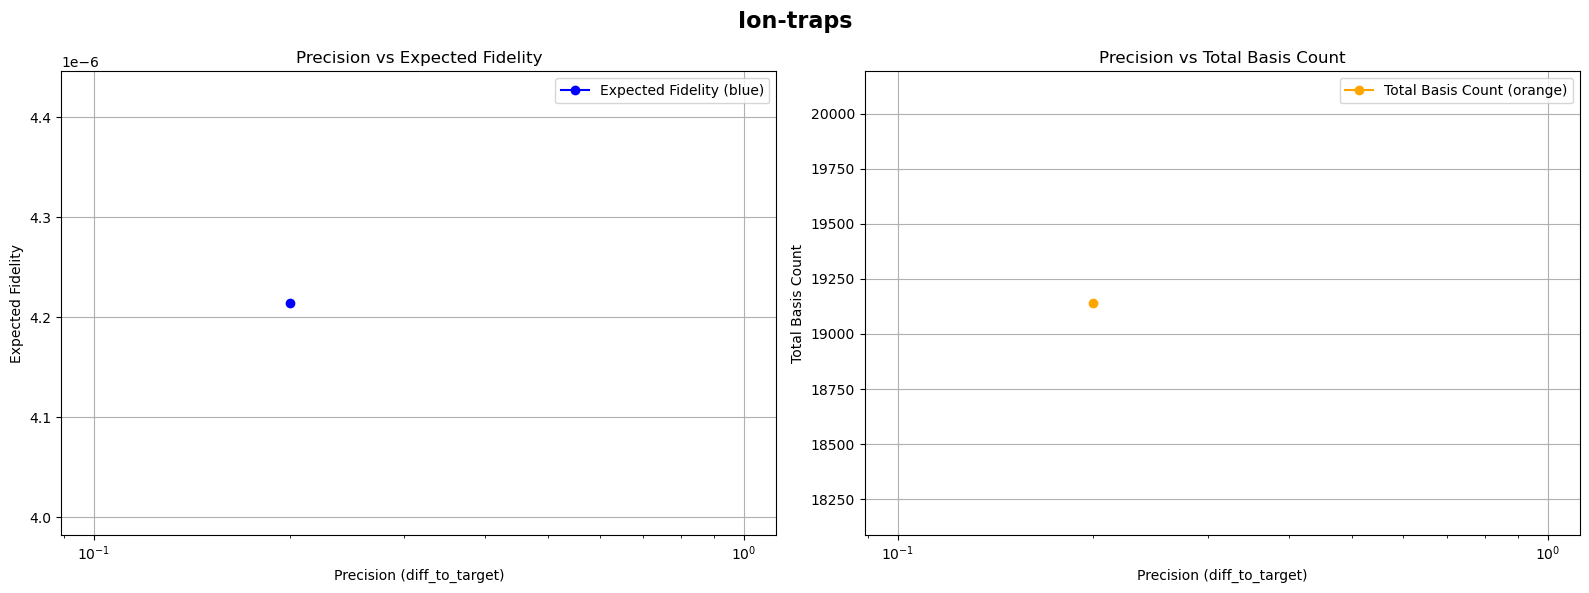

In [13]:
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383


# 修改 main_loop 增加 diff_threshold 参数
def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)  # 如果电路里没有这个门，默认 count=0
        fidelity *= (1 - error_rate) ** count
        #print(f"Gate: {gate}, Count: {count}, Error: {error_rate}, Contribution: {(1 - error_rate) ** count:.6f}")
    fidelity *= readout_fidelity
    return fidelity

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

basis_gates = ["gpi", "gpi2", "zz"]

gate_error = {
    "gpi": 2e-4,      # 1-qubit
    "gpi2": 2e-4,      # 1-qubit    
    "zz": 5.1e-3,      # 1-qubit
}


coupling_map = CouplingMap.from_full(4)



# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")


# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

total_count_list = []  # 存储每个 precision 下的 gate 总数
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)
    for gate, count in transpiled_circuit.count_ops().items():
        print(f"Gate: {gate}, Count: {count}")


    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.6f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main title for the entire figure
fig.suptitle('Ion-traps', fontsize=16, fontweight='bold')

# Plot 1: Precision vs Expected Fidelity
ax1.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
ax2.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

Testing different topologies for Heron, Eagle, and Ion Trap Processors...

Testing Heron Processor
Gate median errors:
  id: 0.0002738
  rx: 0.0002738
  rz: 0.0
  sx: 0.0002738
  x: 0.0002738
  cz: 0.001947
  rzz: 0.00249

Testing Heron - Topo1...
Expected fidelity reached threshold for Heron - Topo1, stopping early.
Heron - Topo1 completed with 5 data points

Testing Heron - Topo2...
Expected fidelity reached threshold for Heron - Topo2, stopping early.
Heron - Topo2 completed with 2 data points

Testing Heron - Topo3...
Expected fidelity reached threshold for Heron - Topo3, stopping early.
Heron - Topo3 completed with 10 data points

Testing Heron - Topo4...
Expected fidelity reached threshold for Heron - Topo4, stopping early.
Heron - Topo4 completed with 10 data points

Testing Heron - Topo5...
Expected fidelity reached threshold for Heron - Topo5, stopping early.
Heron - Topo5 completed with 7 data points

Testing Eagle Processor
Gate median errors:
  ecr: 0.005824
  id: 0.0002252

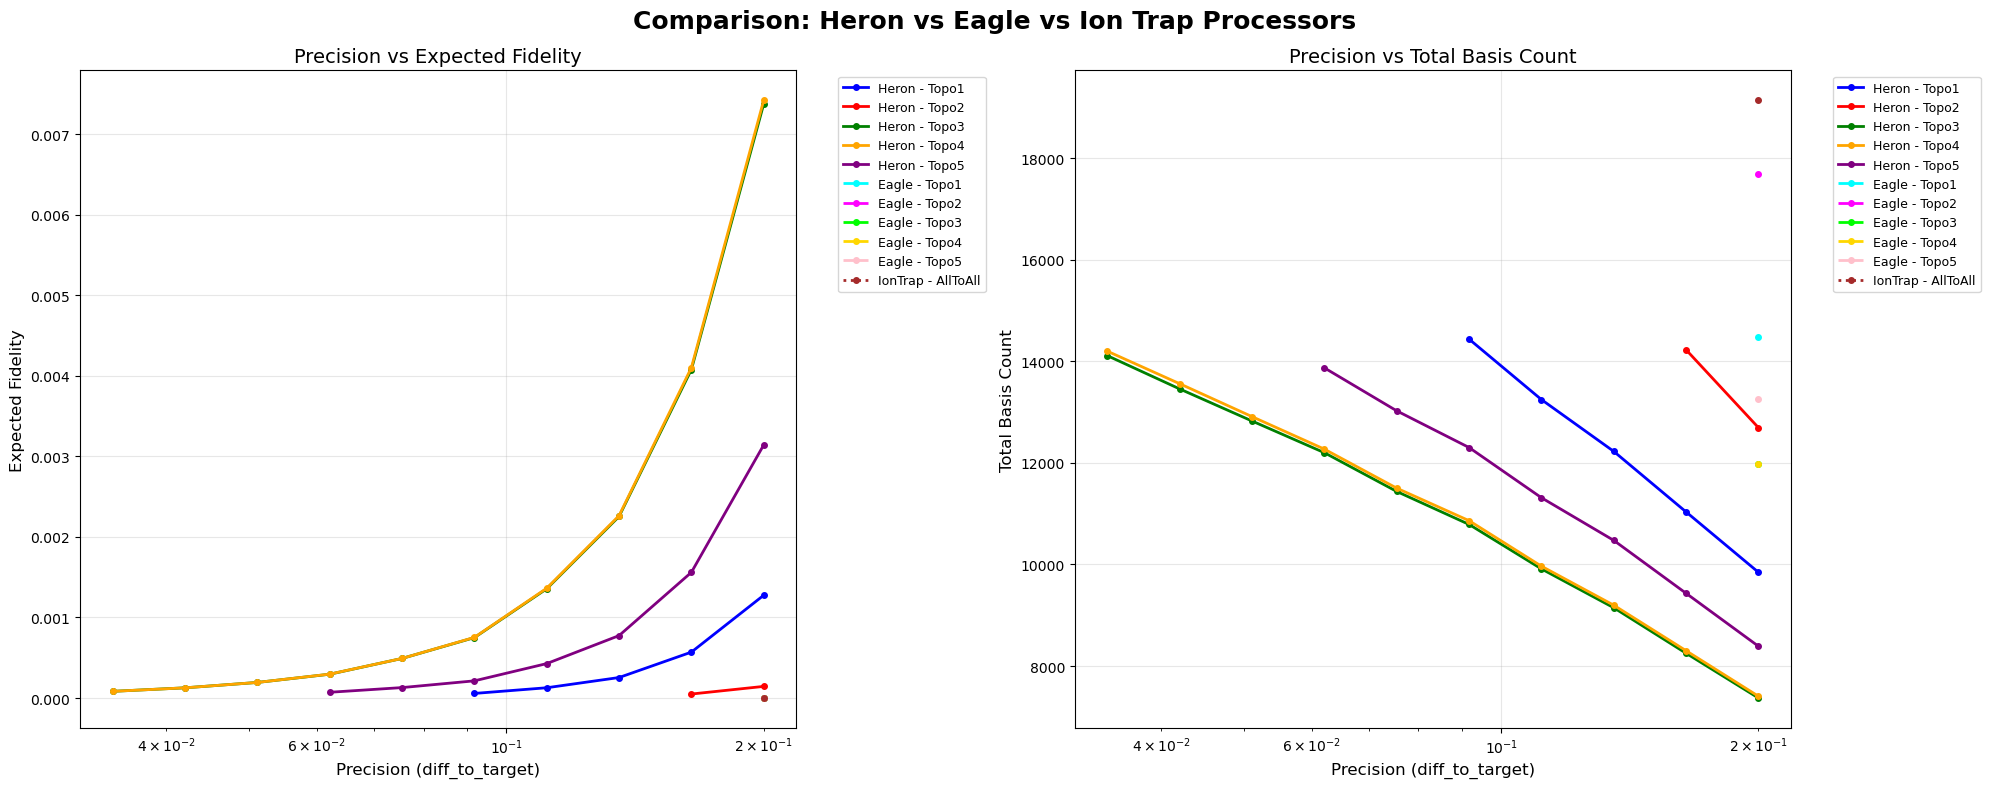


COMPREHENSIVE SUMMARY STATISTICS

HERON PROCESSOR RESULTS:
----------------------------------------
Topo1:
  Maximum Fidelity: 0.001276
  Minimum Gate Count: 9846
  Data Points: 5
Topo2:
  Maximum Fidelity: 0.000144
  Minimum Gate Count: 12693
  Data Points: 2
Topo3:
  Maximum Fidelity: 0.007373
  Minimum Gate Count: 7371
  Data Points: 10
Topo4:
  Maximum Fidelity: 0.007419
  Minimum Gate Count: 7406
  Data Points: 10
Topo5:
  Maximum Fidelity: 0.003141
  Minimum Gate Count: 8390
  Data Points: 7

EAGLE PROCESSOR RESULTS:
----------------------------------------
Topo1:
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 14483
  Data Points: 1
Topo2:
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 17684
  Data Points: 1
Topo3:
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11981
  Data Points: 1
Topo4:
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 11980
  Data Points: 1
Topo5:
  Maximum Fidelity: 0.000000
  Minimum Gate Count: 13258
  Data Points: 1

ION TRAP PROCESSOR RESU

In [14]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider
# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    },
    "IonTrap": {
        "basis_gates": ["gpi", "gpi2", "zz"],
        "gate_error": {
            "gpi": 2e-4,
            "gpi2": 2e-4,
            "zz": 5.1e-3,
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# Ion Trap 专用全连接拓扑
ion_trap_topology = CouplingMap.from_full(4)

# 生成精度阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)

# 存储所有结果
all_results = {}

print("Testing different topologies for Heron, Eagle, and Ion Trap Processors...")

# 对Heron和Eagle处理器的每个拓扑运行实验
for processor_name, processor_config in processors.items():
    if processor_name == "IonTrap":  # 跳过IonTrap，单独处理
        continue
        
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    print("Gate median errors:")
    for gate, error in gate_error.items():
        print(f"  {gate}: {error}")
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} - {topo_name}"
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        fidelity_list = []
        total_count_list = []
        
        for threshold in precision_list:
            # 初始化电路
            qc_initial = uniform_superposition_circuit()
            
            # 运行 main_loop
            beta_list, energy_list, final_circuit = main_loop_2(
                qc=qc_initial,
                cost_h=cost_h,
                driver_h=driver_h,
                comm_h=comm_h,
                delta_t=delta_t,
                beta_0=beta_0,
                n_steps=n_steps,
                diff_threshold=threshold
            )

            # Transpile 电路
            transpiled_circuit = transpile(
                final_circuit,
                basis_gates=basis_gates,
                coupling_map=coupling_map,
                optimization_level=1
            )

            # 统计 gate count
            gate_counts = transpiled_circuit.count_ops()
            total_count = sum(gate_counts.values())
            total_count_list.append(total_count)

            # 计算 expected fidelity
            expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
            fidelity_list.append(expected_fidelity)
            
            # 如果保真度太低就提前退出
            if expected_fidelity < 0.0001:
                print(f"Expected fidelity reached threshold for {combined_name}, stopping early.")
                break
        
        # 存储结果
        all_results[combined_name] = {
            'precision': precision_list[:len(fidelity_list)],
            'fidelity': fidelity_list,
            'gate_count': total_count_list,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"{combined_name} completed with {len(fidelity_list)} data points")

# 单独处理Ion Trap (All-to-All拓扑)
print(f"\n{'='*50}")
print(f"Testing IonTrap Processor")
print(f"{'='*50}")

processor_config = processors["IonTrap"]
basis_gates = processor_config["basis_gates"]
gate_error = processor_config["gate_error"]

print("Gate median errors:")
for gate, error in gate_error.items():
    print(f"  {gate}: {error}")

combined_name = "IonTrap - AllToAll"
print(f"\nTesting {combined_name}...")

fidelity_list = []
total_count_list = []

for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=ion_trap_topology,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())
    total_count_list.append(total_count)

    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    
    # 如果保真度太低就提前退出
    if expected_fidelity < 0.0001:
        print(f"Expected fidelity reached threshold for {combined_name}, stopping early.")
        break

# 存储Ion Trap结果
all_results[combined_name] = {
    'precision': precision_list[:len(fidelity_list)],
    'fidelity': fidelity_list,
    'gate_count': total_count_list,
    'processor': "IonTrap",
    'topology': "AllToAll"
}

print(f"{combined_name} completed with {len(fidelity_list)} data points")

# 绘制合并图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparison: Heron vs Eagle vs Ion Trap Processors', fontsize=18, fontweight='bold')

# 定义颜色和线型
heron_colors = ['blue', 'red', 'green', 'orange', 'purple']
eagle_colors = ['cyan', 'magenta', 'lime', 'gold', 'pink']
ion_trap_color = 'brown'
heron_linestyle = '-'
eagle_linestyle = '--'
ion_trap_linestyle = ':'

# Plot 1: Precision vs Expected Fidelity
heron_results = []
eagle_results = []

for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[len(heron_results)]
        linestyle = heron_linestyle
        heron_results.append(combined_name)
    elif results['processor'] == 'Eagle':
        color = eagle_colors[len(eagle_results)]
        linestyle = eagle_linestyle
        eagle_results.append(combined_name)
    else:  # IonTrap
        color = ion_trap_color
        linestyle = ion_trap_linestyle
    
    ax1.plot(results['precision'], results['fidelity'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Precision vs Expected Fidelity', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Plot 2: Precision vs Total Basis Count
for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[heron_results.index(combined_name)]
        linestyle = heron_linestyle
    elif results['processor'] == 'Eagle':
        color = eagle_colors[eagle_results.index(combined_name)]
        linestyle = eagle_linestyle
    else:  # IonTrap
        color = ion_trap_color
        linestyle = ion_trap_linestyle
    
    ax2.plot(results['precision'], results['gate_count'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)', fontsize=12)
ax2.set_ylabel('Total Basis Count', fontsize=12)
ax2.set_title('Precision vs Total Basis Count', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# 打印汇总统计
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*80)

print("\nHERON PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\nEAGLE PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Eagle':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\nION TRAP PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'IonTrap':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("• Heron processor uses solid lines (-), Eagle processor uses dashed lines (--), Ion Trap uses dotted lines (:)")
print("• Heron basis gates: ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']")
print("• Eagle basis gates: ['ecr', 'id', 'rz', 'sx', 'x']")
print("• Ion Trap basis gates: ['gpi', 'gpi2', 'zz']")
print("• Ion Trap has all-to-all connectivity advantage")
print("• Different processors show varying performance trade-offs across precision levels")

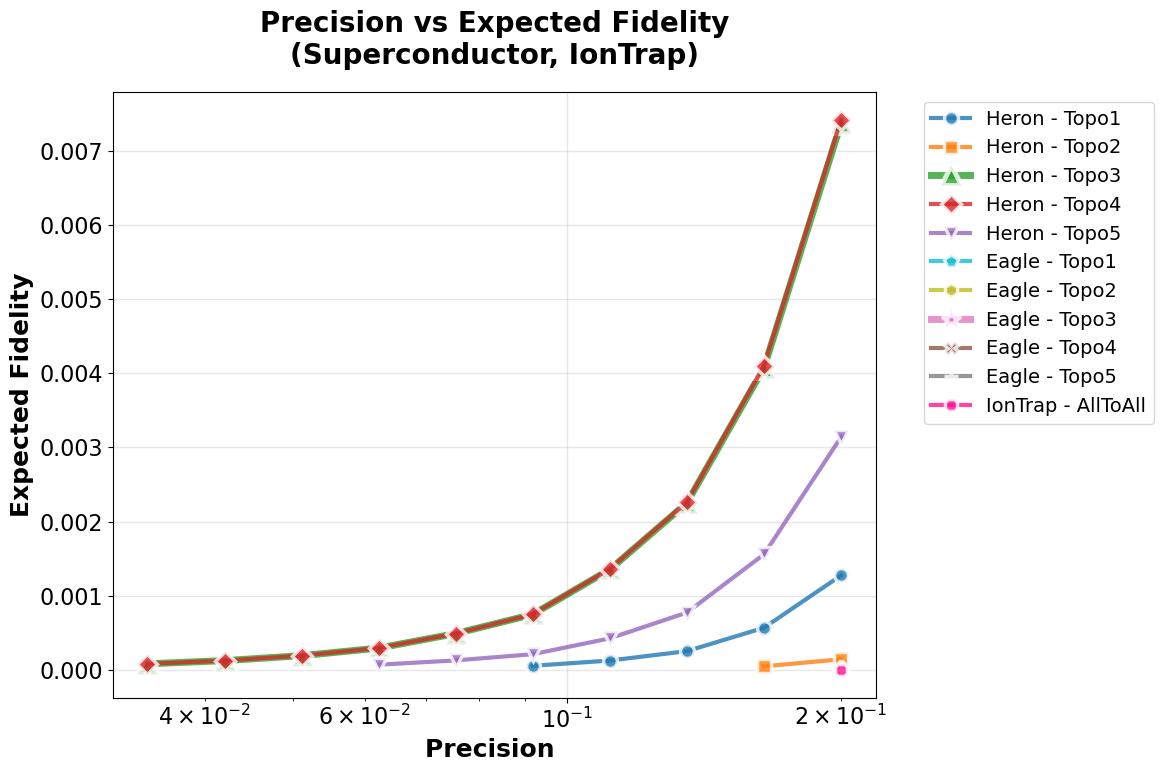

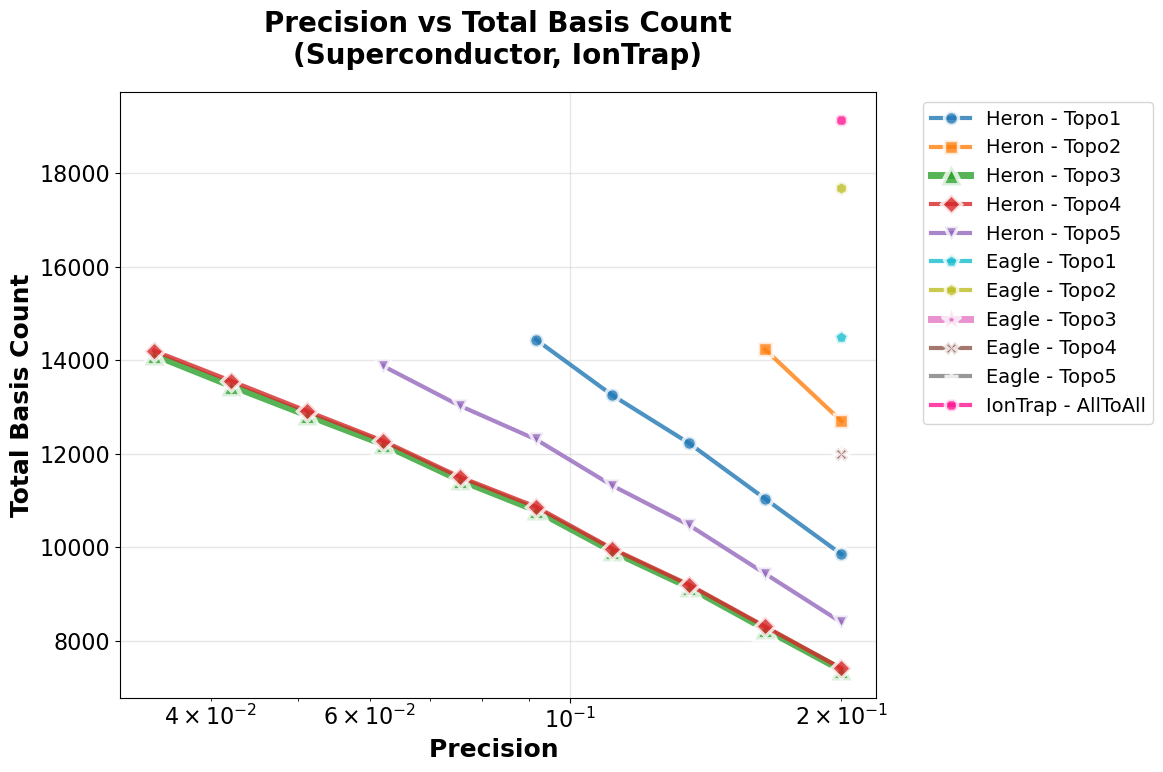

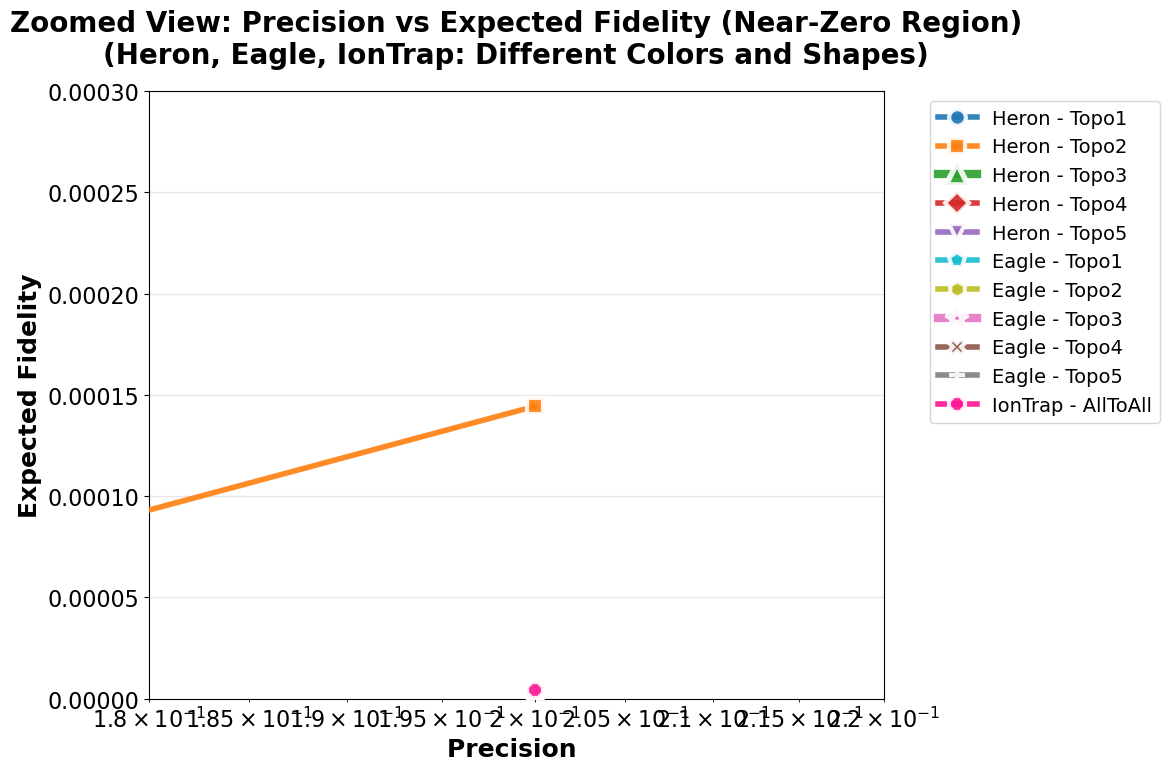

In [17]:
# 改进的绘图代码 - 支持Heron, Eagle, IonTrap三种处理器
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# 设置更大的字体
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# 防色盲的颜色和标记样式
heron_styles = [
    {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-'},      # 蓝色，圆圈
    {'color': '#ff7f0e', 'marker': 's', 'linestyle': '-'},      # 橙色，方块
    {'color': '#2ca02c', 'marker': '^', 'linestyle': '-'},      # 绿色，三角形
    {'color': '#d62728', 'marker': 'D', 'linestyle': '-'},      # 红色，菱形
    {'color': '#9467bd', 'marker': 'v', 'linestyle': '-'}       # 紫色，倒三角形
]

eagle_styles = [
    {'color': '#17becf', 'marker': 'p', 'linestyle': '-'},      # 青色，五角星
    {'color': '#bcbd22', 'marker': 'h', 'linestyle': '-'},      # 橄榄色，六边形
    {'color': '#e377c2', 'marker': '*', 'linestyle': '-'},      # 粉色，星号
    {'color': '#8c564b', 'marker': 'X', 'linestyle': '-'},      # 棕色，X形
    {'color': '#7f7f7f', 'marker': '+', 'linestyle': '-'}       # 灰色，加号
]

# IonTrap专用样式
iontrap_style = {'color': '#ff1493', 'marker': '8', 'linestyle': '-'}  # 深粉色，八边形

# 创建三个独立的图
fig1, ax1 = plt.subplots(figsize=(12, 8))
fig2, ax2 = plt.subplots(figsize=(12, 8))
fig3, ax3 = plt.subplots(figsize=(12, 8))

# 绘制第一个图：Precision vs Expected Fidelity
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax1.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('Precision ', fontweight='bold')
ax1.set_ylabel('Expected Fidelity', fontweight='bold')
ax1.set_title('Precision vs Expected Fidelity\n(Superconductor, IonTrap)', 
              fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linewidth=1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 绘制第二个图：Precision vs Total Basis Count
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax2.plot(results['precision'], results['gate_count'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name,
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax2.set_xscale('log')
ax2.set_xlabel('Precision ', fontweight='bold')
ax2.set_ylabel('Total Basis Count', fontweight='bold')
ax2.set_title('Precision vs Total Basis Count\n(Superconductor, IonTrap)', 
              fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linewidth=1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 创建第三个图：放大拥挤区域
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 6
        markersize = 16
        markeredgewidth = 4
    else:
        linewidth = 4
        markersize = 12
        markeredgewidth = 3
    
    ax3.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.9, markevery=1)

# 设置放大区域的范围 - 专注在0.2附近的x值和0以上的y值
ax3.set_xlim(0.18, 0.22)  # 专注在0.2这个区域
ax3.set_ylim(0.0, 0.0003)  # 只关心0以上的值

ax3.set_xscale('log')
ax3.set_xlabel('Precision ', fontweight='bold')
ax3.set_ylabel('Expected Fidelity', fontweight='bold')
ax3.set_title('Zoomed View: Precision vs Expected Fidelity (Near-Zero Region)\n(Heron, Eagle, IonTrap: Different Colors and Shapes)', 
              fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, linewidth=1)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局并显示
plt.figure(fig1.number)
plt.tight_layout()
plt.figure(fig2.number)
plt.tight_layout()
plt.figure(fig3.number)
plt.tight_layout()
plt.show()

Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...

Testing Heron Processor

Testing Heron Topo1...
  Expected Fidelity: 0.904922
  Total Gate Count: 154
  Energy: -0.767453

Testing Heron Topo2...
  Expected Fidelity: 0.865394
  Total Gate Count: 210
  Energy: -0.767453

Testing Heron Topo3...
  Expected Fidelity: 0.918831
  Total Gate Count: 130
  Energy: -0.767453

Testing Heron Topo4...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Heron Topo5...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Eagle Processor

Testing Eagle Topo1...
  Expected Fidelity: 0.742181
  Total Gate Count: 229
  Energy: -0.767453

Testing Eagle Topo2...
  Expected Fidelity: 0.664809
  Total Gate Count: 296
  Energy: -0.767453

Testing Eagle Topo3...
  Expected Fidelity: 0.770212
  Total Gate Count: 205
  Energy: -0.767453

Testing Eagle Topo4...
  Expected Fidelity: 0.784181
  Total Gate Count: 198
  Energy: -0.76

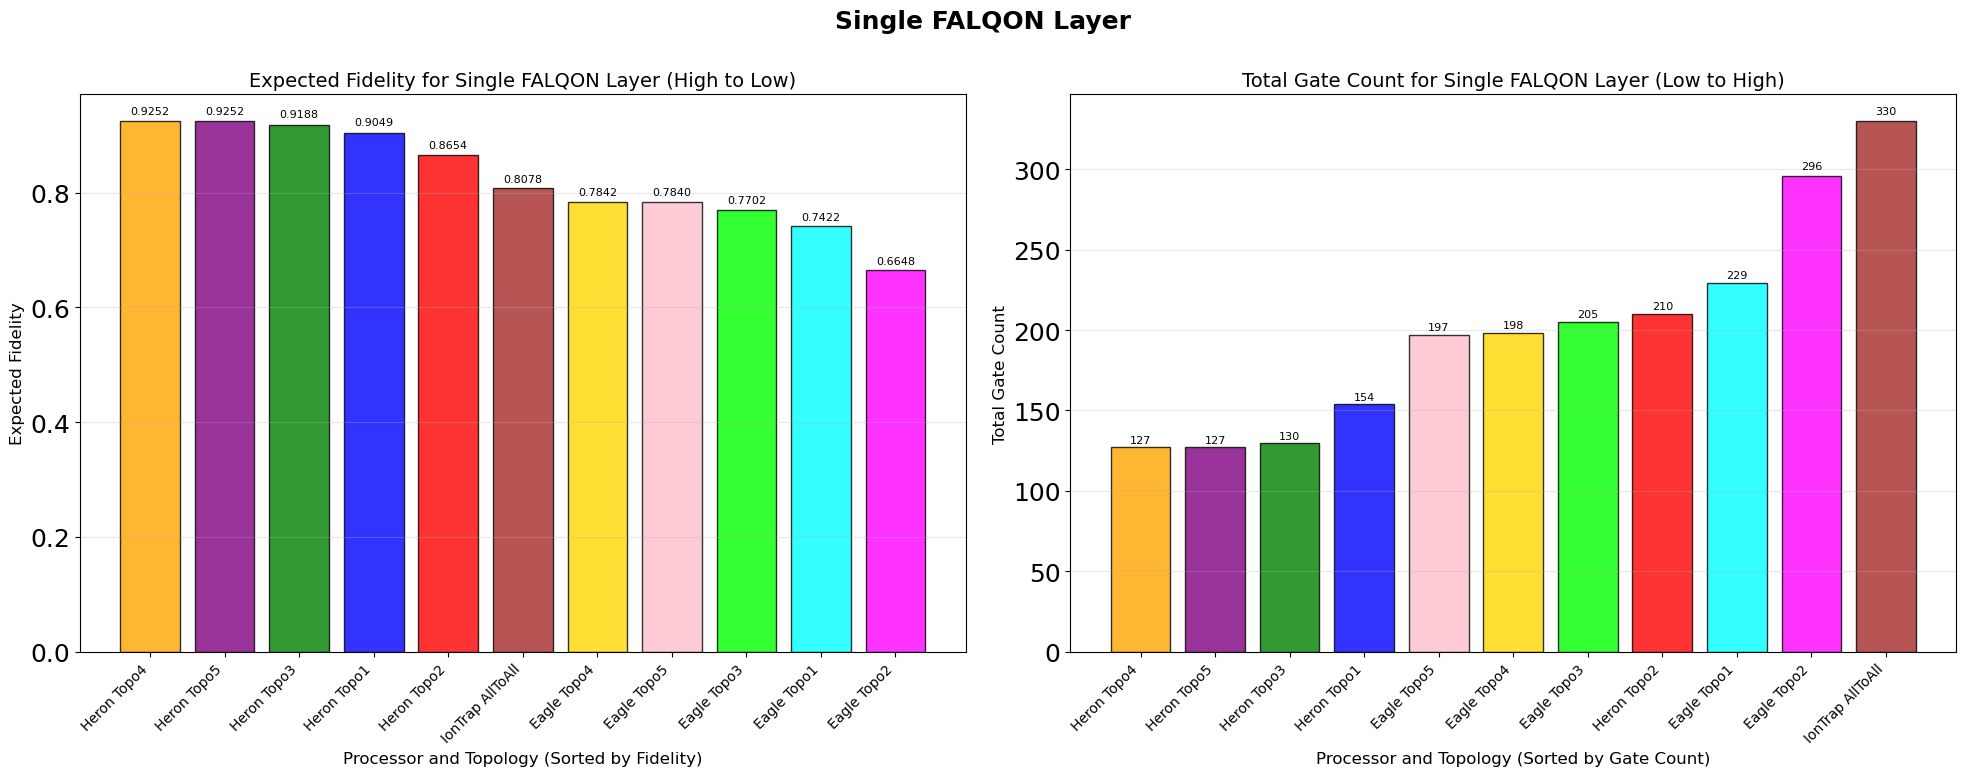


SINGLE FALQON LAYER - DETAILED RESULTS

RESULTS SORTED BY EXPECTED FIDELITY (High to Low):
Rank  Processor-Topology   Fidelity     Gate Count  
------------------------------------------------------------
1     Heron Topo4          0.925232     127         
2     Heron Topo5          0.925232     127         
3     Heron Topo3          0.918831     130         
4     Heron Topo1          0.904922     154         
5     Heron Topo2          0.865394     210         
6     IonTrap AllToAll     0.807835     330         
7     Eagle Topo4          0.784181     198         
8     Eagle Topo5          0.784004     197         
9     Eagle Topo3          0.770212     205         
10    Eagle Topo1          0.742181     229         
11    Eagle Topo2          0.664809     296         

RESULTS SORTED BY GATE COUNT (Low to High):
Rank  Processor-Topology   Gate Count   Fidelity    
------------------------------------------------------------
1     Heron Topo4          127          0.925232    

In [19]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def single_falqon_step(qc, cost_h, driver_h, comm_h, delta_t, beta_0):
    """运行单个FALQON步骤"""
    state = Statevector.from_label("+" * n_qubits)
    
    # 单个FALQON层
    qc_layer = QuantumCircuit(n_qubits)
    falqon_layer(qc_layer, cost_h, driver_h, beta_0, delta_t)
    qc.compose(qc_layer, inplace=True)
    state = state.evolve(qc_layer)
    
    # 计算能量和下一个beta
    energy = state.expectation_value(cost_h).real
    next_beta = -1 * state.expectation_value(comm_h).real
    
    return qc, energy, next_beta

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    },
    "IonTrap": {
        "basis_gates": ["gpi", "gpi2", "zz"],
        "gate_error": {
            "gpi": 2e-4,
            "gpi2": 2e-4,
            "zz": 5.1e-3,
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# Ion Trap 专用全连接拓扑
ion_trap_topology = {
    "AllToAll": CouplingMap.from_full(4)  # 全连接拓扑
}

# 存储所有结果
all_results = {}
labels = []

print("Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...")

# 对Heron和Eagle处理器的每个拓扑运行实验
for processor_name, processor_config in processors.items():
    if processor_name == "IonTrap":  # 跳过IonTrap，单独处理
        continue
        
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} {topo_name}"
        labels.append(combined_name)
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行单个FALQON步骤
        final_circuit, energy, next_beta = single_falqon_step(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
        
        # 存储结果
        all_results[combined_name] = {
            'fidelity': expected_fidelity,
            'gate_count': total_count,
            'energy': energy,
            'next_beta': next_beta,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"  Expected Fidelity: {expected_fidelity:.6f}")
        print(f"  Total Gate Count: {total_count}")
        print(f"  Energy: {energy:.6f}")

# 单独处理Ion Trap (All-to-All拓扑)
print(f"\n{'='*50}")
print(f"Testing IonTrap Processor")
print(f"{'='*50}")

processor_config = processors["IonTrap"]
basis_gates = processor_config["basis_gates"]
gate_error = processor_config["gate_error"]

combined_name = "IonTrap AllToAll"
labels.append(combined_name)
print(f"\nTesting {combined_name}...")

coupling_map = ion_trap_topology["AllToAll"]

# 初始化电路
qc_initial = uniform_superposition_circuit()

# 运行单个FALQON步骤
final_circuit, energy, next_beta = single_falqon_step(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0
)

# Transpile 电路
transpiled_circuit = transpile(
    final_circuit,
    basis_gates=basis_gates,
    coupling_map=coupling_map,
    optimization_level=1
)

# 统计 gate count
gate_counts = transpiled_circuit.count_ops()
total_count = sum(gate_counts.values())

# 计算 expected fidelity
expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)

# 存储结果
all_results[combined_name] = {
    'fidelity': expected_fidelity,
    'gate_count': total_count,
    'energy': energy,
    'next_beta': next_beta,
    'processor': "IonTrap",
    'topology': "AllToAll"
}

print(f"  Expected Fidelity: {expected_fidelity:.6f}")
print(f"  Total Gate Count: {total_count}")
print(f"  Energy: {energy:.6f}")

# 准备绘图数据并排序
# 创建包含所有信息的元组列表 (label, fidelity, gate_count, color_index)
plot_data = []
for i, label in enumerate(labels):
    plot_data.append((
        label, 
        all_results[label]['fidelity'], 
        all_results[label]['gate_count'],
        i  # 原始颜色索引
    ))

# 按保真度降序排序（高到低）
sorted_by_fidelity = sorted(plot_data, key=lambda x: x[1], reverse=True)

# 按门数升序排序（低到高）  
sorted_by_gate_count = sorted(plot_data, key=lambda x: x[2])

# 定义颜色 - 11种不同颜色
colors = ['blue', 'red', 'green', 'orange', 'purple', 
          'cyan', 'magenta', 'lime', 'gold', 'pink', 'brown']

# 创建柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Single FALQON Layer', fontsize=18, fontweight='bold')

# 柱状图1: Expected Fidelity (按保真度从高到低排序)
fidelity_labels = [item[0] for item in sorted_by_fidelity]
fidelity_values = [item[1] for item in sorted_by_fidelity]
fidelity_colors = [colors[item[3]] for item in sorted_by_fidelity]

bars1 = ax1.bar(range(len(fidelity_labels)), fidelity_values, color=fidelity_colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Processor and Topology (Sorted by Fidelity)', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Expected Fidelity for Single FALQON Layer (High to Low)', fontsize=14)
ax1.set_xticks(range(len(fidelity_labels)))
ax1.set_xticklabels(fidelity_labels, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, fidelity) in enumerate(zip(bars1, fidelity_values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{fidelity:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 柱状图2: Total Gate Count (按门数从低到高排序)
gate_labels = [item[0] for item in sorted_by_gate_count]
gate_values = [item[2] for item in sorted_by_gate_count]
gate_colors = [colors[item[3]] for item in sorted_by_gate_count]

bars2 = ax2.bar(range(len(gate_labels)), gate_values, color=gate_colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Processor and Topology (Sorted by Gate Count)', fontsize=12)
ax2.set_ylabel('Total Gate Count', fontsize=12)
ax2.set_title('Total Gate Count for Single FALQON Layer (Low to High)', fontsize=14)
ax2.set_xticks(range(len(gate_labels)))
ax2.set_xticklabels(gate_labels, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, count) in enumerate(zip(bars2, gate_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# 打印详细统计（按排序后的顺序）
print("\n" + "="*80)
print("SINGLE FALQON LAYER - DETAILED RESULTS")
print("="*80)

print("\nRESULTS SORTED BY EXPECTED FIDELITY (High to Low):")
print(f"{'Rank':<5} {'Processor-Topology':<20} {'Fidelity':<12} {'Gate Count':<12}")
print("-" * 60)
for i, (label, fidelity, gate_count, _) in enumerate(sorted_by_fidelity, 1):
    print(f"{i:<5} {label:<20} {fidelity:<12.6f} {gate_count:<12}")

print("\nRESULTS SORTED BY GATE COUNT (Low to High):")
print(f"{'Rank':<5} {'Processor-Topology':<20} {'Gate Count':<12} {'Fidelity':<12}")
print("-" * 60)
for i, (label, fidelity, gate_count, _) in enumerate(sorted_by_gate_count, 1):
    print(f"{i:<5} {label:<20} {gate_count:<12} {fidelity:<12.6f}")

# 找出最佳性能
print(f"\n{'='*80}")
print("PERFORMANCE ANALYSIS")
print("="*80)

best_fidelity = max(all_results.items(), key=lambda x: x[1]['fidelity'])
best_gate_count = min(all_results.items(), key=lambda x: x[1]['gate_count'])

print(f"Highest Fidelity: {best_fidelity[0]} with {best_fidelity[1]['fidelity']:.6f}")
print(f"Lowest Gate Count: {best_gate_count[0]} with {best_gate_count[1]['gate_count']} gates")

# 按处理器分组统计
print(f"\nHERON PROCESSOR AVERAGE:")
heron_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Heron']
heron_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Heron']
print(f"  Average Fidelity: {np.mean(heron_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(heron_gates):.1f}")

print(f"\nEAGLE PROCESSOR AVERAGE:")
eagle_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Eagle']
eagle_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Eagle']
print(f"  Average Fidelity: {np.mean(eagle_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(eagle_gates):.1f}")

print("\nION TRAP PROCESSOR AVERAGE:")
ion_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
ion_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
if ion_fidelities:  # 检查是否有IonTrap结果
    print(f"  Average Fidelity: {np.mean(ion_fidelities):.6f}")
    print(f"  Average Gate Count: {np.mean(ion_gates):.1f}")

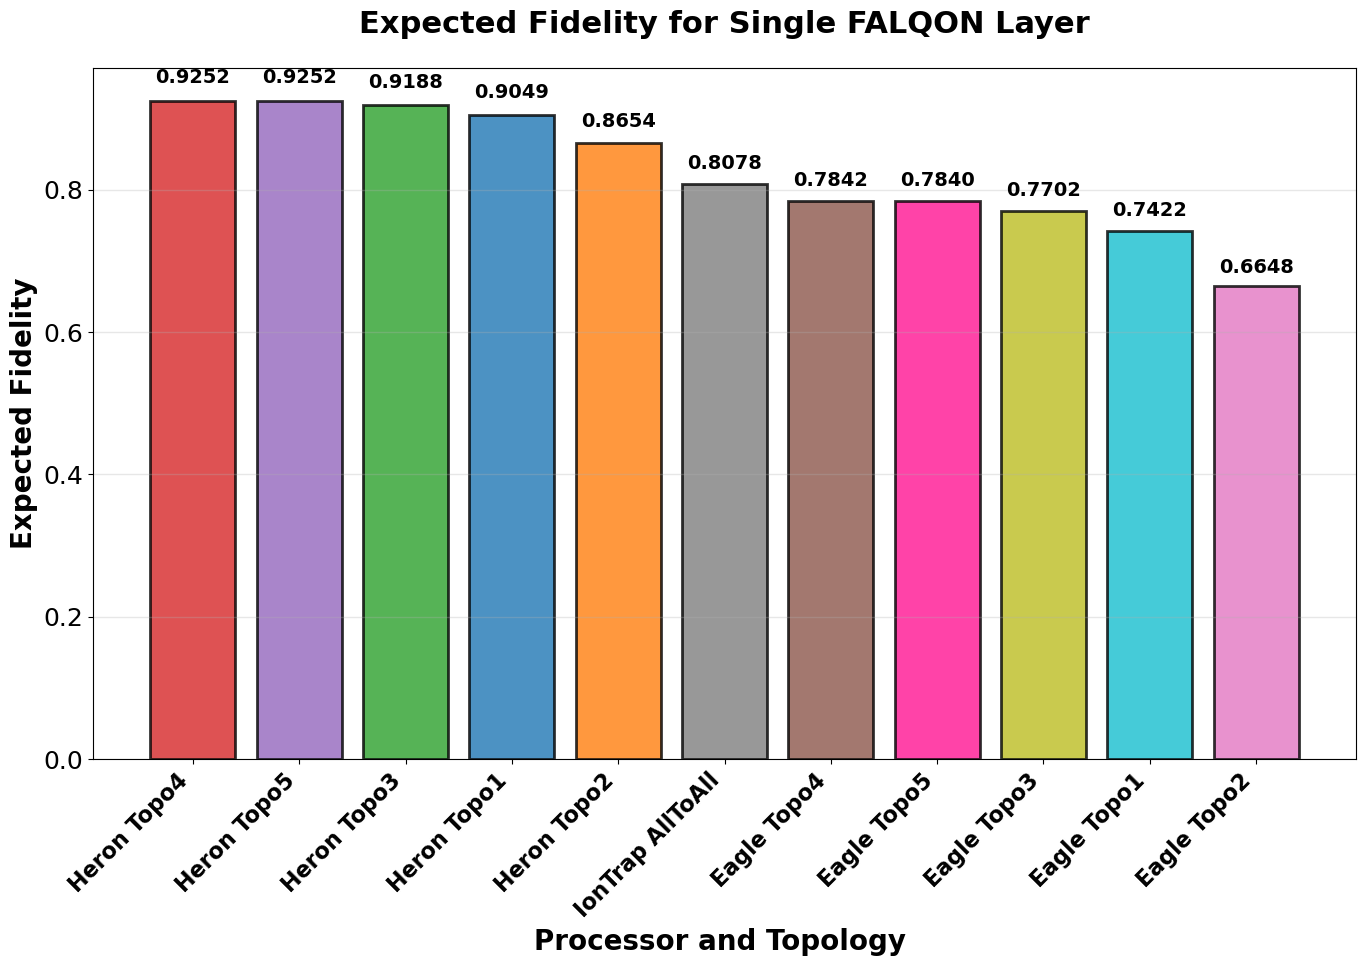

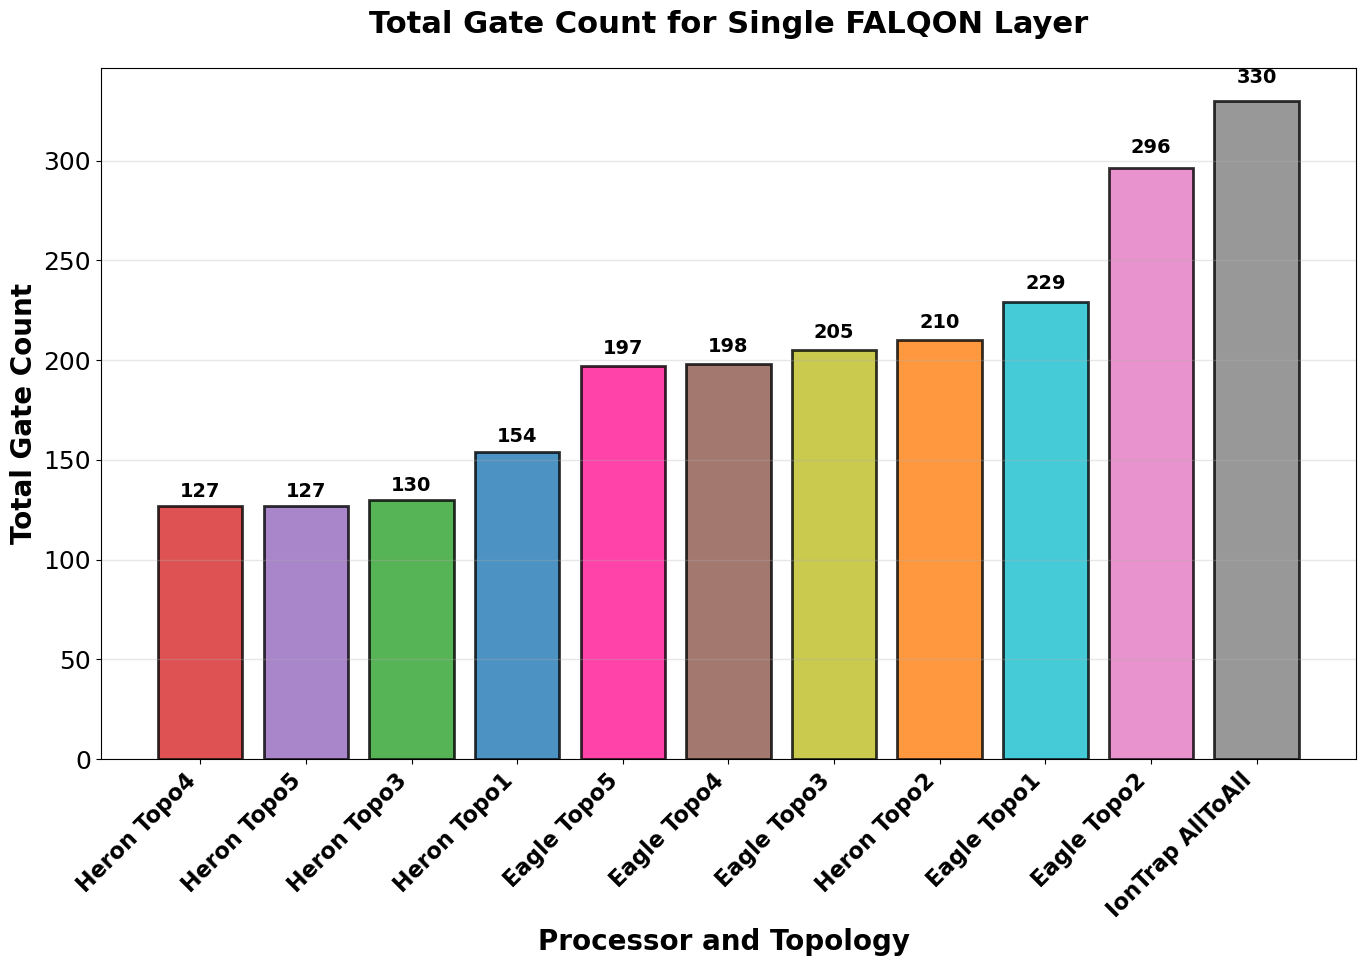

In [21]:
# 改进的柱状图绘图代码 - 单个FALQON层结果
import matplotlib.pyplot as plt
import numpy as np

# 设置更大的字体
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 18
})

# 准备绘图数据并排序
# 创建包含所有信息的元组列表 (label, fidelity, gate_count, color_index)
plot_data = []
for i, label in enumerate(labels):
    plot_data.append((
        label, 
        all_results[label]['fidelity'], 
        all_results[label]['gate_count'],
        i  # 原始颜色索引
    ))

# 按保真度降序排序（高到低）
sorted_by_fidelity = sorted(plot_data, key=lambda x: x[1], reverse=True)

# 按门数升序排序（低到高）  
sorted_by_gate_count = sorted(plot_data, key=lambda x: x[2])

# 定义颜色 - 11种不同颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#17becf', '#e377c2', '#bcbd22', '#8c564b', '#ff1493', '#7f7f7f']

# 创建两个独立的图
fig1, ax1 = plt.subplots(figsize=(14, 10))
fig2, ax2 = plt.subplots(figsize=(14, 10))

# 第一张图: Expected Fidelity (按保真度从高到低排序)
fidelity_labels = [item[0] for item in sorted_by_fidelity]
fidelity_values = [item[1] for item in sorted_by_fidelity]
fidelity_colors = [colors[item[3]] for item in sorted_by_fidelity]

bars1 = ax1.bar(range(len(fidelity_labels)), fidelity_values, 
                color=fidelity_colors, alpha=0.8, edgecolor='black', 
                linewidth=2, width=0.8)

ax1.set_xlabel('Processor and Topology ', fontweight='bold')
ax1.set_ylabel('Expected Fidelity', fontweight='bold')
ax1.set_title('Expected Fidelity for Single FALQON Layer', 
              fontweight='bold', pad=25)
ax1.set_xticks(range(len(fidelity_labels)))
ax1.set_xticklabels(fidelity_labels, rotation=45, ha='right', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y', linewidth=1)

# 在柱子上方添加数值标签
for i, (bar, fidelity) in enumerate(zip(bars1, fidelity_values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{fidelity:.4f}', ha='center', va='bottom', 
             fontsize=14, fontweight='bold', rotation=0)

# 第二张图: Total Gate Count (按门数从低到高排序)
gate_labels = [item[0] for item in sorted_by_gate_count]
gate_values = [item[2] for item in sorted_by_gate_count]
gate_colors = [colors[item[3]] for item in sorted_by_gate_count]

bars2 = ax2.bar(range(len(gate_labels)), gate_values, 
                color=gate_colors, alpha=0.8, edgecolor='black', 
                linewidth=2, width=0.8)

ax2.set_xlabel('Processor and Topology ', fontweight='bold')
ax2.set_ylabel('Total Gate Count', fontweight='bold')
ax2.set_title('Total Gate Count for Single FALQON Layer', 
              fontweight='bold', pad=25)
ax2.set_xticks(range(len(gate_labels)))
ax2.set_xticklabels(gate_labels, rotation=45, ha='right', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y', linewidth=1)

# 在柱子上方添加数值标签
for i, (bar, count) in enumerate(zip(bars2, gate_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{count}', ha='center', va='bottom', 
             fontsize=14, fontweight='bold', rotation=0)

# 调整布局并显示
plt.figure(fig1.number)
plt.tight_layout()
plt.figure(fig2.number)
plt.tight_layout()
plt.show()